<a href="https://colab.research.google.com/github/fespinozav/ECG-DL-MITBIH/blob/main/Medical_Signal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atrial Fibrillation (AF) classification with MIT-BIH AF Database

In this tutorial, we explore the classification of Atriual Fibrillation in Electrocardiogram (ECG) signals using a ResNet18-based neural network.

---



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
! unzip -n /content/drive/MyDrive/MIT-BIH_AF.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./MIT-BIH_AF/processed_data/06453_277_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/07879_16_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/08219_913_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/08434_703_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/04746_847_AFIB.npz  
  inflating: ./MIT-BIH_AF/processed_data/06426_166_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/04126_658_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/08455_347_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/08219_581_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/08455_1188_AFIB.npz  
  inflating: ./MIT-BIH_AF/processed_data/06426_264_AFIB.npz  
  inflating: ./MIT-BIH_AF/processed_data/07879_1031_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/08215_313_AFIB.npz  
  inflating: ./MIT-BIH_AF/processed_data/05091_645_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/04048_716_N.npz  
  inflating: ./MIT-BIH_AF/processed_data/04015_221_

In [3]:
!pip install monai
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [4]:
# import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [5]:
# Load data (04043)
import wfdb
signal = wfdb.rdrecord('/content/MIT-BIH_AF/04043').p_signal.T
annotation = wfdb.rdann('/content/MIT-BIH_AF/04043', 'atr')
timestamps = annotation.sample
labels = annotation.aux_note

print(f"signal: {signal}, shape={signal.shape}")
print()
print(f"timestamps: {timestamps}, len={len(timestamps)}")
print()
print(f"labels: {labels}, len={len(labels)}")

signal: [[-0.415 -0.415 -0.43  ...  0.175  0.08  -0.03 ]
 [-0.395 -0.26  -0.185 ... -0.14  -0.16  -0.25 ]], shape=(2, 9205760)

timestamps: [     68  266498  376328 2585284 2602516 2634911 2739812 2745162 2779581
 2834739 2841728 3119235 3121706 3324526 3352183 3607124 3637519 3665624
 3680630 3690356 3707032 3714455 3729454 3757893 3850173 3864338 3882086
 3911965 3939729 3947348 3992719 4002976 4067053 4100718 4135455 4144613
 4180313 4184151 4207223 4216965 4232561 4397189 4429652 4469008 4475226
 4484786 4508435 4527258 4551868 4572558 4602709 4627077 4636998 4650429
 4700108 4846373 4859020 4977503 5001899 5025436 5047415 5064396 5076309
 5093223 5105440 5122383 5136042 5143706 5152531 5223157 5237640 5245920
 5258589 5269137 5310430 5328717 5383211 5412443 5446749 5481762 5504398
 5518464 5535882 5559927 5576037 5592280 5633072 5668367 5685492 5713187
 5719861 5746977 5774762 5797297 5822969 5859230 5866172 5891680 5931746
 6129598 6142319 6167966 6200373 6254934 6273886 6378723 

We then define a dictionary annotation_colors that maps different annotation labels to specific colors. it then uses Matplotlib to create a plot of the ECG signal with annotated events where event is represented by a vertical dashed line with a corresponding label.

<function matplotlib.pyplot.show(close=None, block=None)>

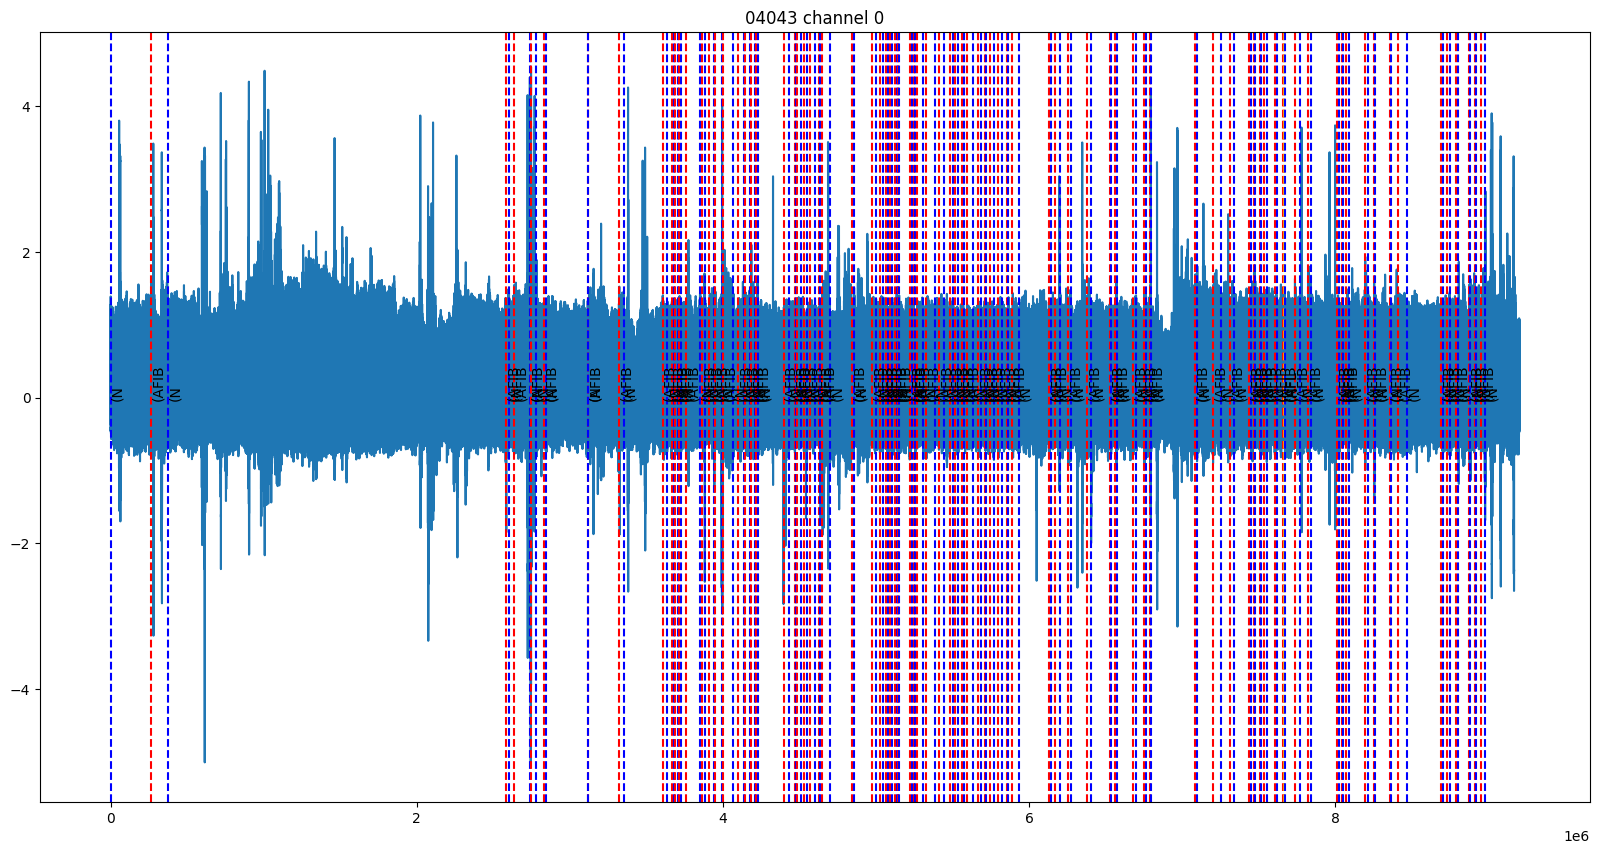

In [6]:
annotation_colors = {
    "(N": "blue",
    "(AFIB": "red",
    "(AFL": "orange",
    "(J": "green"
}

# Plot data with annotations
plt.figure(figsize=(20, 10))
plt.plot(signal[0])
for timestamp, label in zip(timestamps, labels):
    plt.axvline(x=timestamp, color=annotation_colors[label], linestyle='--',)
    plt.text(timestamp, 0, label, rotation=90)
plt.title("04043 channel 0")
plt.show

We will have to zoom in to see better

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

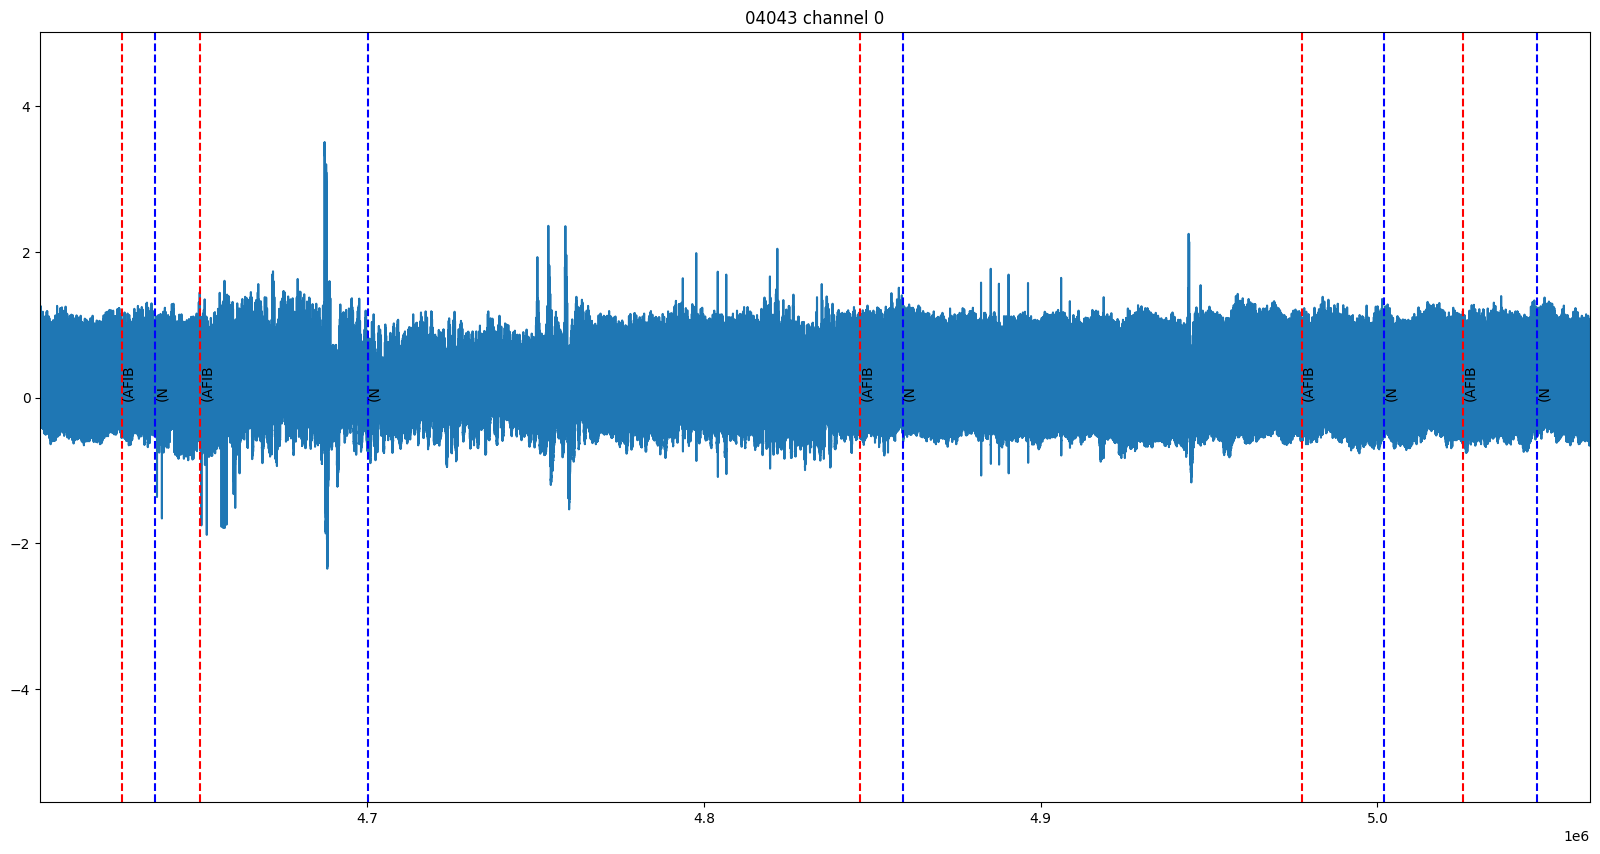

In [7]:
# Plot data with annotations and zoom in

start = int(0.5 * len(signal[0]))
end = int(0.55 * len(signal[0]))

plt.figure(figsize=(20, 10))
plt.plot(signal[0])
for timestamp, label in zip(timestamps, labels):
  if not start < timestamp < end:
    continue
  plt.axvline(x=timestamp, color=annotation_colors[label], linestyle='--',)
  plt.text(timestamp, 0, label, rotation=90)
plt.title("04043 channel 0")
#Zoom in
plt.axis([start, end, None, None])
plt.show
plt.close

Zoom in further

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

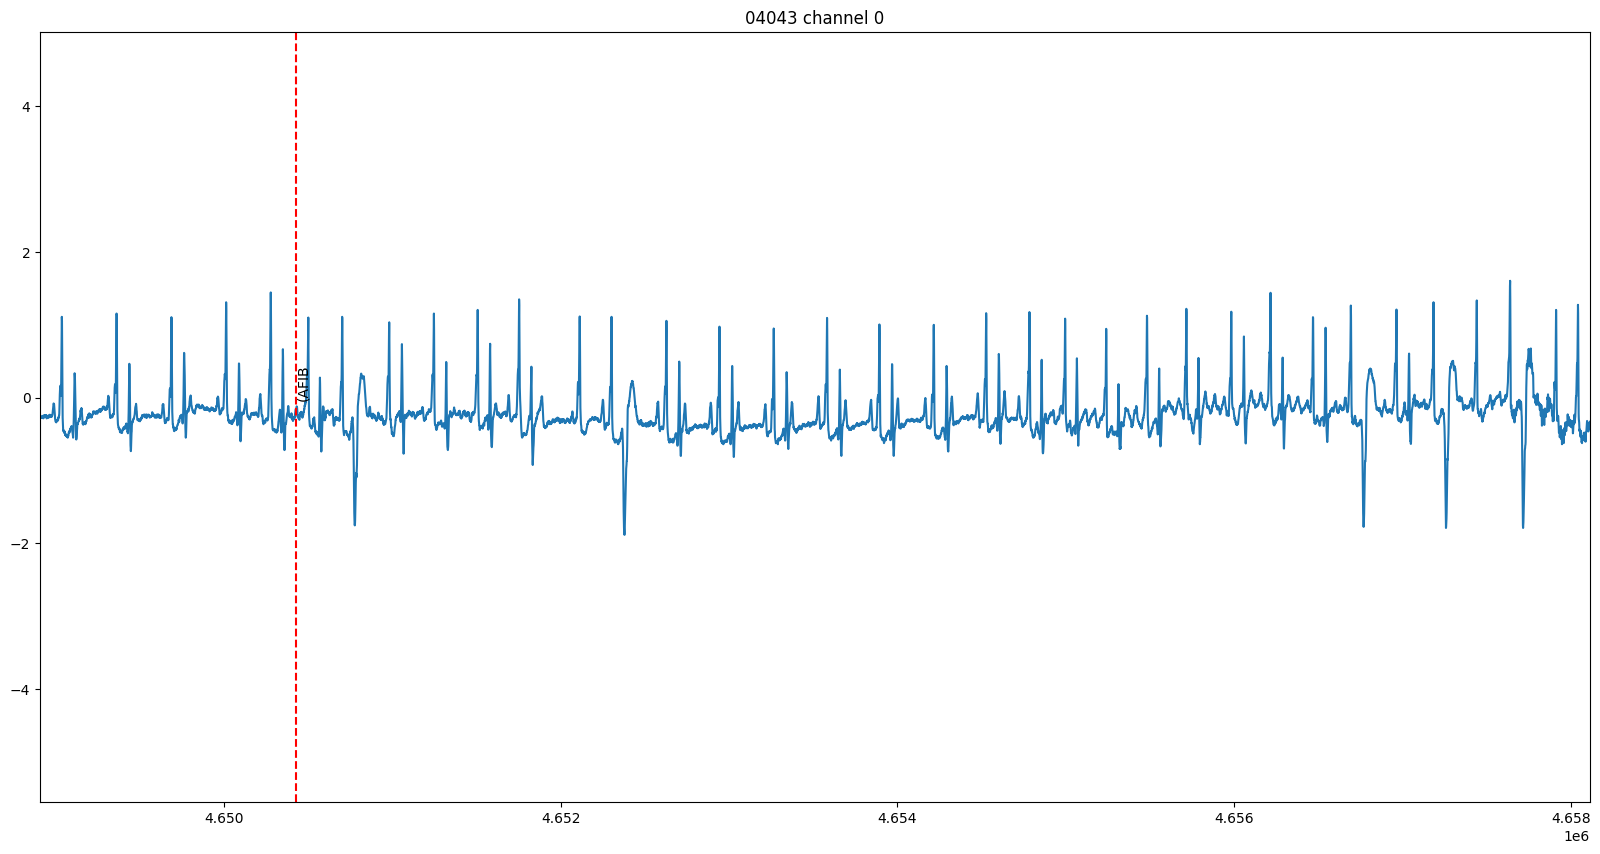

In [8]:
# Plot data with annotations and zoom in
start = int(0.505 * len(signal[0]))
end = int(0.506 * len(signal[0]))

plt.figure(figsize=(20, 10))
plt.plot(signal[0])
for timestamp, label in zip(timestamps, labels):
  if not start < timestamp < end:
    continue
  plt.axvline(x=timestamp, color=annotation_colors[label], linestyle='--',)
  plt.text(timestamp, 0, label, rotation=90)
plt.title("04043 channel 0")
#Zoom in
plt.axis([start, end, None, None])
plt.show
plt.close

Now we try to load the filenames of all MIT-BIH Af databse. This is needed later, as we will have to ensure that every sample of a patient only appears in either training, validation or test set.

In [9]:
data_path = "/content/MIT-BIH_AF/processed_data"
df = pd.read_csv(os.path.join(data_path, "index.csv"), dtype=str)

print(df.head())
print(df.columns)

        filename record label label_id filename_label   fs start_samp  \
0  04015_0_N.npz  04015     N        1              N  250         30   
1  04015_1_N.npz  04015     N        1              N  250       7530   
2  04015_2_N.npz  04015     N        1              N  250      15030   
3  04015_3_N.npz  04015     N        1              N  250      22530   
4  04015_4_N.npz  04015     N        1              N  250      30030   

  end_samp start_sec end_sec  
0     7530      0.12   30.12  
1    15030     30.12   60.12  
2    22530     60.12   90.12  
3    30030     90.12  120.12  
4    37530    120.12  150.12  
Index(['filename', 'record', 'label', 'label_id', 'filename_label', 'fs',
       'start_samp', 'end_samp', 'start_sec', 'end_sec'],
      dtype='object')


In [10]:
data_path = "/content/MIT-BIH_AF/processed_data"

filenames = df["filename"].tolist()

print("Raw filenames:")
print(filenames[:10])   # muestra los primeros 10
print("Total:", len(filenames))

Raw filenames:
['04015_0_N.npz', '04015_1_N.npz', '04015_2_N.npz', '04015_3_N.npz', '04015_4_N.npz', '04015_5_N.npz', '04015_6_N.npz', '04015_7_N.npz', '04015_8_N.npz', '04015_9_N.npz']
Total: 26473


To ensure reproducibility, use set_determinism from MONAI library to ensure deterministic behavior during training and inference.



In [11]:
# Set determinism
from monai.utils import set_determinism
set_determinism(seed=42)

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


Perform a random shuffle of the raw filenames and the divides then into training, validation and test sets.

In [12]:
#Split rae filenames into train, validation, and test sets

np.random.shuffle(filenames)
train_split = 0.8
validation_split = 0.1

train_filenames = filenames[:int(train_split * len(filenames))]
validation_filenames = filenames[int(train_split * len(filenames)):int((train_split + validation_split) * len(filenames))]
test_filenames = filenames[int((train_split + validation_split) * len(filenames)):]

print(f"Number of training samples: {len(train_filenames)}")
print(f"Number of validation samples: {len(validation_filenames)}")
print(f"Number of test samples: {len(test_filenames)}")


Number of training samples: 21178
Number of validation samples: 2647
Number of test samples: 2648


Files "07162" and "07859" cannot used for validation or test since they are comprised of AFIB

In [13]:
# Only use file 07162 and 07859 for training
for filename in ["07162", "07859"]:
  if filename in validation_filenames:
    validation_filenames.remove(filename)
    validation_filenames.append(train_filenames[0])
    train_filenames.remove(train_filenames[0])
    train_filenames.append(filename)
  if filename in test_filenames:
    test_filenames.remove(filename)
    test_filenames.append(train_filenames[0])
    train_filenames.remove(train_filenames[0])
    train_filenames.append(filename)

We are ready to load in the samples

In [14]:
# Get filenames of samples
samples = sorted(glob(os.path.join(data_path, "*.npz")))

print(f"First 5 samples: {samples[:5]}")
print(f"Number of samples: {len(samples)}")

First 5 samples: ['/content/MIT-BIH_AF/processed_data/04015_0_N.npz', '/content/MIT-BIH_AF/processed_data/04015_1000_N.npz', '/content/MIT-BIH_AF/processed_data/04015_1001_N.npz', '/content/MIT-BIH_AF/processed_data/04015_1002_N.npz', '/content/MIT-BIH_AF/processed_data/04015_1003_N.npz']
Number of samples: 26473


Let us take a look at the firs example.
start and stop record the timestamps cropped of the raw data.


In [15]:
import numpy as np
d = np.load("/content/MIT-BIH_AF/processed_data/04015_349_N.npz", allow_pickle=True)
x = d["x"]
print(x.shape)

(2, 7500)


In [16]:
# Inspect the first sample
sample = np.load(samples[0], allow_pickle=True)

for x, v in sample.items():
  print(f"{x} : {v}")


x : [[-0.115 -0.09  -0.1   ... -0.52  -0.51  -0.52 ]
 [-0.155 -0.155 -0.23  ... -0.015 -0.015 -0.01 ]]
label : N
label_id : 1
y : [0 1]
labels_vocab : ['AFIB' 'N']
fs : 250.0
record : 04015
start_samp : 30
end_samp : 7530
label_raw : (N


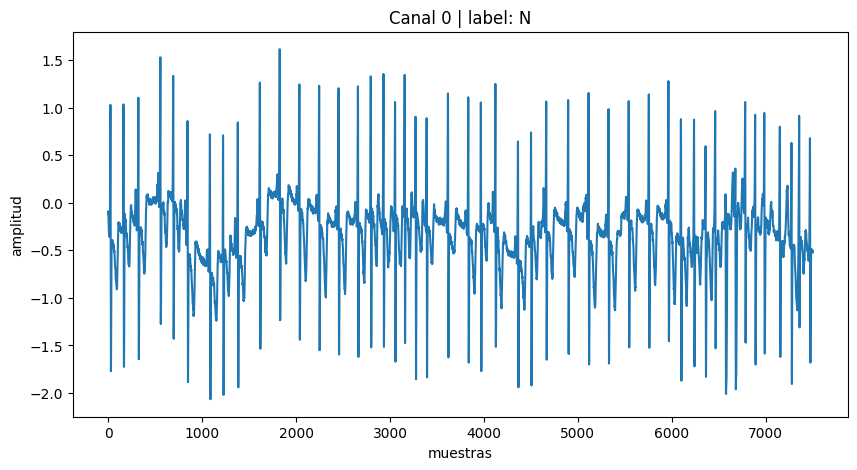

In [17]:
import numpy as np
import matplotlib.pyplot as plt

x = sample["x"]
sig = x[0]

# Convertir label a string “limpio”
lab = sample["label"]
if isinstance(lab, np.ndarray):
    lab = lab.item()
if isinstance(lab, bytes):
    lab = lab.decode("utf-8")
lab = str(lab)

plt.figure(figsize=(10,5))
plt.plot(sig)
plt.title(f"Canal 0 | label: {lab}")
plt.xlabel("muestras")
plt.ylabel("amplitud")
plt.show()
plt.close()

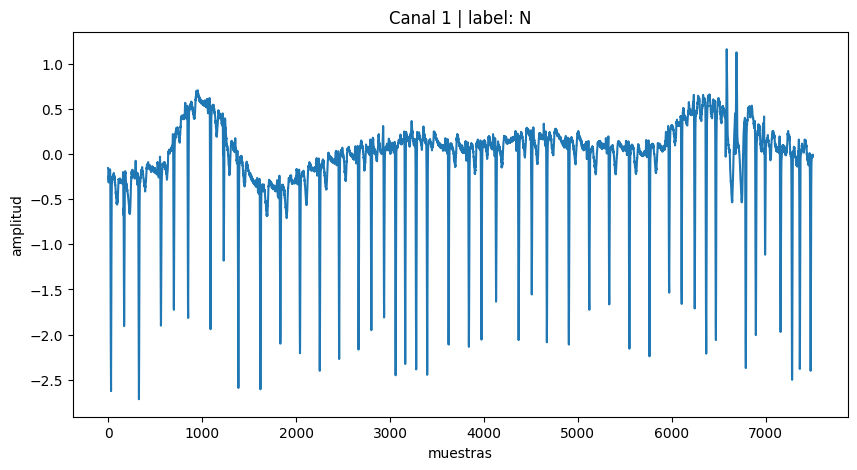

In [18]:
x = sample["x"]
sig = x[1]

# Convertir label a string “limpio”
lab = sample["label"]
if isinstance(lab, np.ndarray):
    lab = lab.item()
if isinstance(lab, bytes):
    lab = lab.decode("utf-8")
lab = str(lab)

plt.figure(figsize=(10,5))
plt.plot(sig)
plt.title(f"Canal 1 | label: {lab}")
plt.xlabel("muestras")
plt.ylabel("amplitud")
plt.show()
plt.close()

Then we organize the samples into training, validation, and test sets based on their filenames and creates dictionaries for each sample containing the ECG signal data and its corresponding label.

In [19]:
allowed_labels = {"N", "AFIB"}
samples = [p for p in samples
           if os.path.basename(p).split(".")[0].split("_")[-1] in allowed_labels]

In [20]:
# Split data into train, validation, and test sets
train_data = []
validation_data = []
test_data = []
for sample in samples:
  # Initialize a dictionary to be put into our list of samples
  d={}
  # Extract the (raw) filename and label in the sample
  filename = os.path.basename(sample)   # e.g. '04015_0_N.npz'
  base = filename.split(".")[0]
  parts = base.split("_")
  label_txt = parts[-1]                           # 'N' o 'AFIB'

  label_map = {"AFIB": 0, "N": 1}                 # define tu codificación
  d["signal"] = sample
  d["label"] = label_map[label_txt]
  # Put the sample in the corresponding list
  if filename in train_filenames:
    train_data.append(d)
  elif filename in validation_filenames:
    validation_data.append(d)
  elif filename in test_filenames:
    test_data.append(d)
  else:
    #raise ValueError(f"Error: Filename {filename} not found in any of the sets"
    continue

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(validation_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 21178
Number of validation samples: 2647
Number of test samples: 2648


Opción 2: NO correr si no es necesario

In [21]:
import os

# 1) Convertir filenames -> records (split por record para evitar leakage)
train_records = {f.split("_")[0] for f in train_filenames}
val_records   = {f.split("_")[0] for f in validation_filenames}
test_records  = {f.split("_")[0] for f in test_filenames}

# (opcional) sanity check
print("records train/val/test:", len(train_records), len(val_records), len(test_records))
print("overlap train-val:", len(train_records & val_records))
print("overlap train-test:", len(train_records & test_records))
print("overlap val-test:", len(val_records & test_records))

# 2) Asignar cada sample por record (todas las ventanas del mismo record al mismo split)
train_data, validation_data, test_data = [], [], []

label_map = {"AFIB": 0, "N": 1}

for sample in samples:
    fname = os.path.basename(sample)         # ej: 04015_0_N.npz
    parts = fname.split(".")[0].split("_")
    rec = parts[0]
    label_txt = parts[-1]

    # por si queda algo raro
    if label_txt not in label_map:
        continue

    d = {"signal": sample, "label": label_map[label_txt]}

    if rec in train_records:
        train_data.append(d)
    elif rec in val_records:
        validation_data.append(d)
    elif rec in test_records:
        test_data.append(d)
    else:
        continue  # records que no estén en ningún split

print("train/val/test:", len(train_data), len(validation_data), len(test_data))

records train/val/test: 22 22 22
overlap train-val: 22
overlap train-test: 22
overlap val-test: 22
train/val/test: 26473 0 0


In [22]:
import os, random

records = sorted({os.path.basename(p).split("_")[0] for p in samples})

random.seed(0)
random.shuffle(records)

n = len(records)
train_records = set(records[:int(0.8*n)])
val_records   = set(records[int(0.8*n):int(0.9*n)])
test_records  = set(records[int(0.9*n):])

print(len(train_records), len(val_records), len(test_records))
print("overlap:", len(train_records&val_records), len(train_records&test_records), len(val_records&test_records))

17 2 3
overlap: 0 0 0


What is exactly in the dictionary?

In [23]:
print("An item in the list of samples")
print(d)

An item in the list of samples
{'signal': '/content/MIT-BIH_AF/processed_data/08455_9_N.npz', 'label': 1}


Note that we have not loaded the data yet, as loading will be done when we start training. here we merely specify the path to the file.

Now we initialize the training process using PyTorch

In [24]:
# Start training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model
from monai.networks.nets import resnet18
model = resnet18(spatial_dims=1, num_classes=2, n_input_channels=2).to(device)
print("Model:")
print(model)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

Using device: cuda
Model:
ResNet(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
 

Usually when handling ECG data, as a standard practice, more preprocessing method as Wiener filter and Butterworth filter will be applied to remove Gaussian noises and baseline wander. The following transform classes provide such functions:

- **NoiseRemovald(...)**: Reduce noise in the ECG signal using a Weiner filter.
- **BaselineWanderRemovald(...)**: Remove baseline wander by applying a high-pass Butterworth filter
- **AlignCenterd(...)**: Align the signal by subtracting the median value from each channel



In [25]:
from typing import Dict, Hashable, Mapping
from scipy.signal import butter, sosfilt, wiener
from monai.config import KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.transforms import MapTransform
from monai.utils.type_conversion import convert_to_tensor, convert_to_numpy

import numpy as np

class NoiseRemovald(MapTransform):
  def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False) -> None:
    super().__init__(keys, allow_missing_keys)

  def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
    d = dict(data)
    for key in self.key_iterator(d):
      signal = convert_to_numpy(d[key])

      # Wiener filter
      for chnl in range(signal.shape[0]):
          with np.errstate(all="ignore"): signal[chnl] = wiener(signal[chnl], mysize=5)

      d[key] = convert_to_tensor(signal, dtype="float32")

    return d

class BaselineWanderRemovald(MapTransform):
  def __init__(self, keys: KeysCollection, fs:int = 250,  allow_missing_keys: bool = False) -> None:
    super().__init__(keys, allow_missing_keys)
    self.fs = fs

  def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
    d = dict(data)
    for key in self.key_iterator(d):
      signal = convert_to_numpy(d[key])

      # High-pass Butterworth filter
      butter_sos = butter(N=1, Wn=1, btype="hp", fs=self.fs, output="sos")
      for chnl in range(signal.shape[0]):
        signal[chnl] = sosfilt(butter_sos, signal[chnl])

      d[key] = convert_to_tensor(signal, dtype="float32")

    return d

class AlignCenterd(MapTransform):
  def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False) -> None:
    super().__init__(keys, allow_missing_keys)
  def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
    d = dict(data)
    for key in self.key_iterator(d):
      signal = convert_to_numpy(d[key])

      # Subtract the median value from each channel
      for chnl in range(signal.shape[0]):
          signal[chnl] = signal[chnl] - np.median(signal[chnl])

      d[key] = convert_to_tensor(signal, dtype="float32")

    return d

class LoadNPZx(MapTransform):
    def __init__(self, keys: KeysCollection, allow_missing_keys=False, npz_key="x"):
        super().__init__(keys, allow_missing_keys)
        self.npz_key = npz_key

    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            path = d[key]              # ruta .npz
            npz = np.load(path, allow_pickle=True)
            d[key] = npz[self.npz_key].astype(np.float32)  # ahora "signal" es array (C, T)
        return d




The following set of transforms is designed to load and convert input data (such as ECG signals) into a format suitable for training neural networks. The final transformed data will consist of tensors for both the input and the corresponding labels.

- **LoadImaged(...)**: Loads image data from a specified dictionary key ("signal" in this case). It uses the NumpyReader to read data stored in numpy format (npz files) and extracts the signal key.
- **Resized(...)**: Resizes the spatial dimensions of the loaded image.
- **RandSpatialCropd(...)**: Randomly crops the spatial dimensions of the loaded image.
- **RandGaussianNoised(...)**: Adds random Gaussian noise to the loaded image.
- **ToTensord(...)**: Converts loaded data to PyTorch tensors. It specifies the keys ("signal" and "label") for which the conversion should be applied

In [26]:
# Define transforms
from monai.transforms import (
    LoadImaged,
    Resized,
    RandSpatialCropd,
    RandGaussianNoised,
    RandScaleIntensityd,
    ToTensord,
    Compose,
)

transforms = Compose([
        #LoadImaged(keys=["signal"],reader="NumpyReader", image_only=True, npz_keys=["signal"]), # For images
        LoadNPZx(keys=["signal"], npz_key="x"),
        Resized(keys=["signal"], spatial_size=[2048]),
        NoiseRemovald(keys=["signal"]),
        BaselineWanderRemovald(keys=["signal"]),
        AlignCenterd(keys=["signal"]),
        #RandSpatialCropd(keys=["signal"], roi_size=[1024], random_size=False),
        #RandGaussianNoised(keys=["signal"], prob=0.5, mean=0.0, std=0.1),
        #RandScaleIntensityd(keys=["signal"], factors=0.1, prob=0.5),
        ToTensord(keys=["signal", "label"])

])


Time to visualize the transforms. Let us at the first training sample untouched:


record: 04015
label: N
start_samp: 30
end_samp: 7530
fs: 250.0


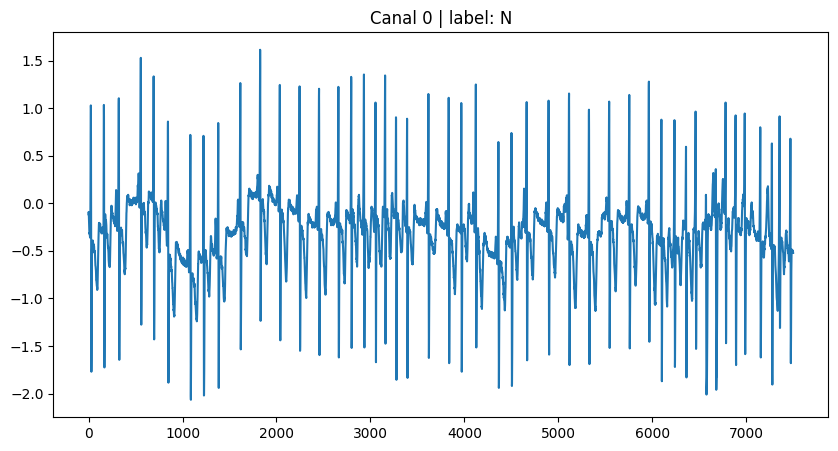

In [27]:
# Plot channel 0 of the first training sample
import numpy as np
import matplotlib.pyplot as plt

p = train_data[0]["signal"]          # ruta al .npz
d = np.load(p, allow_pickle=True)

x = d["x"]                           # (2, 7500)
lab = d["label"]                     # 'N' o 'AFIB'

print("record:", d["record"])        # ej: '04746'  (paciente/registro)
print("label:", d["label"])          # 'N' o 'AFIB'
print("start_samp:", d["start_samp"])
print("end_samp:", d["end_samp"])
print("fs:", d["fs"])

plt.figure(figsize=(10,5))
plt.plot(x[0])                       # canal 0
plt.title(f"Canal 0 | label: {lab}")
plt.show()
plt.close()

After transforms we get:

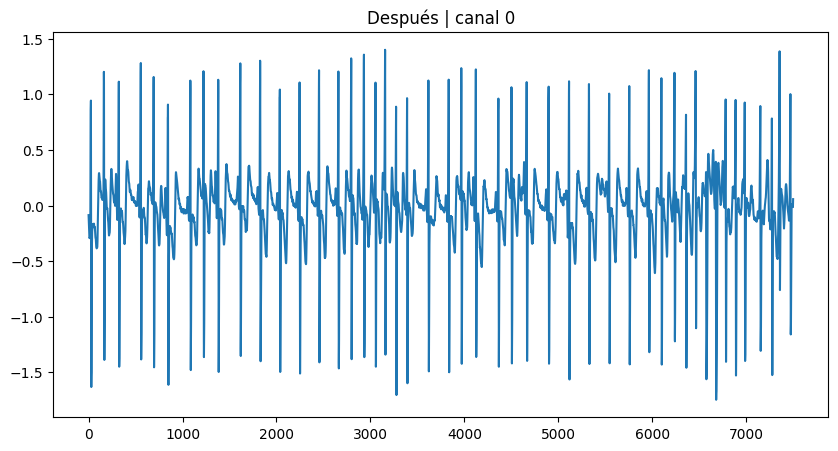

In [28]:
from monai.transforms import Compose

transforms_sig = Compose([
    NoiseRemovald(keys=["signal"]),
    BaselineWanderRemovald(keys=["signal"], fs=250),
    AlignCenterd(keys=["signal"]),
])

out = transforms_sig({"signal": x})
x2 = out["signal"]
try: x2 = x2.detach().cpu().numpy()
except: pass

plt.figure(figsize=(10,5))
plt.plot(x2[0])
plt.title("Después | canal 0")
plt.show()
plt.close()

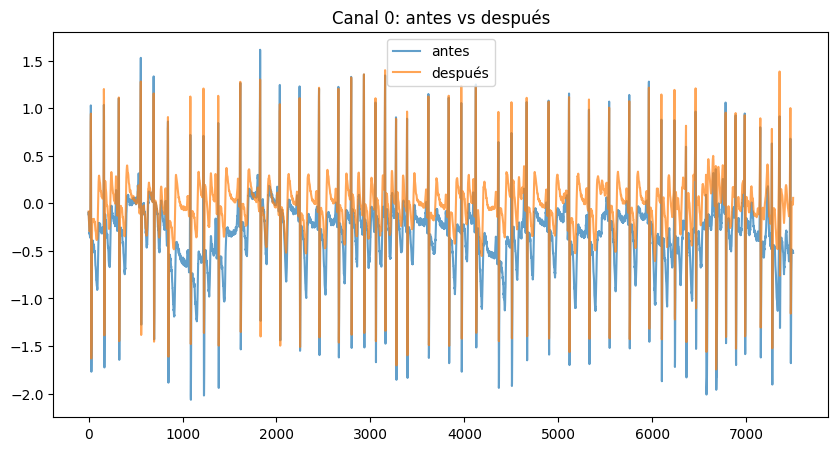

In [29]:
# Versus
plt.figure(figsize=(10,5))
plt.plot(x[0], label="antes", alpha=0.7)
plt.plot(x2[0], label="después", alpha=0.7)
plt.legend()
plt.title("Canal 0: antes vs después")
plt.show()
plt.close()

Feel free to alter the transformations and observe the differences.

Datasets and data loaders are set up to efficiently handle training, validation, and testing. The use of CacheDataset is preferred when sufficient RAM is available, as it can lead to faster data loading.

Here RAM will more than enough since we are using 1-dim data.

In [ ]:
# Define datasets (CacheDatasets are faster but use more RAM)
from monai.data import CacheDataset

train_dataset = CacheDataset(data=train_data, transform=transforms, cache_rate=1.0, num_workers=4)
validation_dataset = CacheDataset(data=validation_data, transform=transforms, cache_rate=1.0, num_workers=4)
test_dataset = CacheDataset(data=test_data, transform=transforms, cache_rate=1.0, num_workers=4)

# Define datasets (Use regular datasets if no available RAM)
#from monai.data import Dataset
#train_dataset = Dataset(data=train_data, transform=transforms)
#validation_dataset = Dataset(data=validation_data, transform=transforms)
#test_dataset = Dataset(data=test_data, transform=transforms)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Loading dataset:  66%|██████▋   | 17597/26473 [01:32<00:42, 211.28it/s]

Next, we define three fuctions for training, validation, and testing.


1.   Training Function(train):
    - Sets the model to training mode.
    - Iterates over batches in the training loader.
    - Performs forward pass, computes loss, and backpropagates to update model parameters.
    - Returns the average training loss.
2.   Validation Function(validate):
    - Sets the model to evaluation mode (no weight updates).
    - Iterates over the batches in the validation loader.
    - Computes validation loss without backpropagation.
    - Returns the average validation loss.
3. Testing fuction (test):
    - Sets the models to evaluation mode.
    - Iterates over the batches in the test loader.
    - Performs inference and collects true and predicted labels
    - Prints a classification report using scikit-learn's classification_report for evaluation.
    



In [ ]:
# Define the training function

def train(model, train_loader, optimizer, loss_fn, device):
  model.train()
  train_loss = 0
  for batch in tqdm(train_loader):
    data = batch["signal"].to(device)
    label = batch["label"].to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, label)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss /= len(train_loader)
  return train_loss

# Define validation function
def validate(model, validation_loader, loss_fn, device):
  model.eval()
  validation_loss = 0
  with torch.no_grad():
    for batch in tqdm(validation_loader):
      data = batch["signal"].to(device)
      label = batch["label"].to(device)
      output = model(data)
      loss = loss_fn(output, label)
      validation_loss += loss.item()
    validation_loss /= len(validation_loader)
    return validation_loss

# Define test function
from sklearn.metrics import classification_report

def test(model, test_loader, device):
  model.eval()
  y_true = []
  y_pred = []
  with torch.no_grad():
    for batch in tqdm(test_loader):
      data = batch["signal"].to(device)
      label = batch["label"].to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)
      y_true.append(label)
      y_pred.append(pred)
  y_true = torch.cat(y_true).cpu().numpy()
  y_pred = torch.cat(y_pred).cpu().numpy()
  print()
  print(classification_report(y_true, y_pred, target_names=["non-AFIB", "AFIB"], digits=4))


What follows is a common structure for training neural networks, where the models is saved if it achieves a better performance on the validation set compared to previus epochs. This helps prevent overffiting and provides the model with the best generalization.

In [ ]:
# Train model and save the best model
epochs = 10
best_loss = None
for epoch in range(epochs):
  train_loss = train(model, train_loader, optimizer, loss_fn, device)
  # Validation loss_fn be changed into some other losses or metrics
  validation_loss = validate(model, validation_loader, loss_fn, device)
  print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}")

  # Save the best model
  if epoch ==0:
    best_loss = validation_loss
    torch.save(model.state_dict(), "resnet18.pt")
  else:
      if validation_loss < best_loss:
        best_loss = validation_loss
        torch.save(model.state_dict(), "resnet18.pt")


In [ ]:
# --- Track metrics to visualize overfitting ---
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

epochs = 10
best_loss = None

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn, device)
    val_loss   = validate(model, validation_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model (early-style checkpoint)
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "resnet18.pt")

# --- Plot Train vs Val loss ---
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Validation Loss (Overfitting check)")
plt.legend()
plt.show()

FInally, load the best-performing model (based on the lowest validation loss) and test it on the test dataset

In [ ]:
# Test model
model.load_state_dict(torch.load("resnet18.pt"))
test(model, test_loader, device)